In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

# Step 1: Load the ping data
file_path = 'o1.txt'  # Update this path to the actual file location
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extracting the timestamp and the ping time with more robust parsing
data = []
for line in lines:
    match = re.search(r'\[(\d+\.\d+)\] 64 bytes from .+ time=(\d+\.\d+)', line)
    if match:
        timestamp = float(match.group(1))
        ping_time = float(match.group(2))
        data.append([timestamp, ping_time])

# Creating a DataFrame
df = pd.DataFrame(data, columns=['Timestamp', 'Ping Time'])

# Converting the timestamps to UTC
df['UTC Time'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)

# Rounding the time to the nearest second for aggregation
df['Rounded Time'] = df['UTC Time'].dt.round('S')

# Calculating the average ping time for each second
average_ping_per_second = df.groupby('Rounded Time')['Ping Time'].mean().reset_index()

# Step 2: Feature Engineering - Adding Lag Features
average_ping_per_second['Lag_1'] = average_ping_per_second['Ping Time'].shift(1)
average_ping_per_second['Lag_2'] = average_ping_per_second['Ping Time'].shift(2)
average_ping_per_second['Lag_3'] = average_ping_per_second['Ping Time'].shift(3)
average_ping_per_second.dropna(inplace=True)

# Step 3: Prepare the data for LSTM
# Sort by Rounded Time
average_ping_per_second = average_ping_per_second.sort_values('Rounded Time')

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(average_ping_per_second[['Ping Time', 'Lag_1', 'Lag_2', 'Lag_3']])

# Convert to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Step 4: Define the model creation function
def create_model(units=100, optimizer='rmsprop', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(SEQ_LENGTH, 4)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 5: Wrap the model using KerasRegressor from SciKeras
model = KerasRegressor(model=create_model, verbose=0, dropout_rate=0.2, units=100, optimizer='rmsprop')

# Step 6: Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Step 7: Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = scaler.inverse_transform(np.concatenate((y_train_pred.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_pred = scaler.inverse_transform(np.concatenate((y_test_pred.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Tuned LSTM Model:')
print(f'Training Mean Absolute Error: {train_mae}')
print(f'Training R^2 Score: {train_r2}')
print(f'Testing Mean Absolute Error: {test_mae}')
print(f'Testing R^2 Score: {test_r2}')
print('-'*30)

# Step 8: Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train)), y_train, color='blue', label='Actual Train')
plt.plot(range(len(y_train)), y_train_pred, color='red', label='Predicted Train')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, color='blue', label='Actual Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred, color='orange', label='Predicted Test')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Ping Time')
plt.title('Actual vs Predicted Ping Time using Tuned LSTM')
plt.show()


Epoch 1/50
Epoch 1: loss = 0.21544429659843445
828/828 - 17s - loss: 0.2154 - 17s/epoch - 20ms/step
Epoch 2/50
Epoch 2: loss = 0.013675972819328308
828/828 - 14s - loss: 0.0137 - 14s/epoch - 17ms/step
Epoch 3/50
Epoch 3: loss = 0.008008334785699844
828/828 - 14s - loss: 0.0080 - 14s/epoch - 17ms/step
Epoch 4/50
Epoch 4: loss = 0.007643728982657194
828/828 - 14s - loss: 0.0076 - 14s/epoch - 17ms/step
Epoch 5/50
Epoch 5: loss = 0.007098443806171417
828/828 - 14s - loss: 0.0071 - 14s/epoch - 17ms/step
Epoch 6/50
Epoch 6: loss = 0.006777377333492041
828/828 - 14s - loss: 0.0068 - 14s/epoch - 17ms/step
Epoch 7/50
Epoch 7: loss = 0.0067064170725643635
828/828 - 14s - loss: 0.0067 - 14s/epoch - 17ms/step
Epoch 8/50
Epoch 8: loss = 0.006976380478590727
828/828 - 15s - loss: 0.0070 - 15s/epoch - 18ms/step
Epoch 9/50
Epoch 9: loss = 0.00676064332947135
828/828 - 14s - loss: 0.0068 - 14s/epoch - 17ms/step
Epoch 10/50
Epoch 10: loss = 0.006372011732310057
828/828 - 14s - loss: 0.0064 - 14s/epoch -

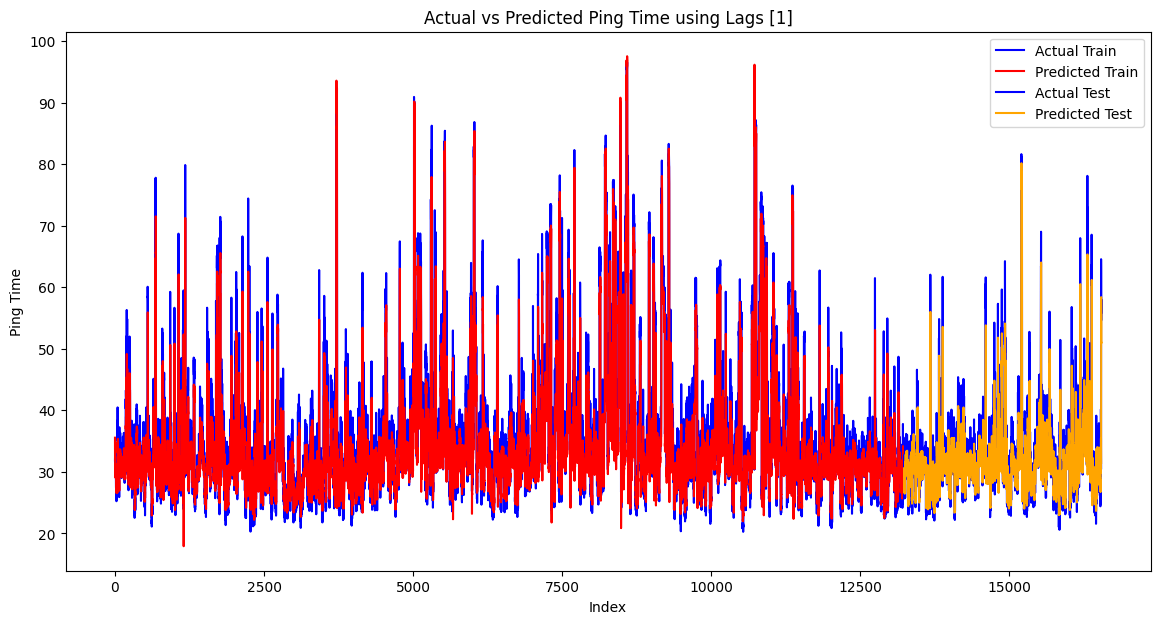

Epoch 1/50
Epoch 1: loss = 0.2713228464126587
827/827 - 9s - loss: 0.2713 - 9s/epoch - 11ms/step
Epoch 2/50
Epoch 2: loss = 0.019974365830421448
827/827 - 6s - loss: 0.0200 - 6s/epoch - 7ms/step
Epoch 3/50
Epoch 3: loss = 0.008713649585843086
827/827 - 6s - loss: 0.0087 - 6s/epoch - 7ms/step
Epoch 4/50
Epoch 4: loss = 0.007666193414479494
827/827 - 6s - loss: 0.0077 - 6s/epoch - 7ms/step
Epoch 5/50
Epoch 5: loss = 0.007617507129907608
827/827 - 6s - loss: 0.0076 - 6s/epoch - 7ms/step
Epoch 6/50
Epoch 6: loss = 0.0072850375436246395
827/827 - 6s - loss: 0.0073 - 6s/epoch - 7ms/step
Epoch 7/50
Epoch 7: loss = 0.007095119915902615
827/827 - 6s - loss: 0.0071 - 6s/epoch - 7ms/step
Epoch 8/50
Epoch 8: loss = 0.0068986727856099606
827/827 - 6s - loss: 0.0069 - 6s/epoch - 7ms/step
Epoch 9/50
Epoch 9: loss = 0.006733214948326349
827/827 - 6s - loss: 0.0067 - 6s/epoch - 7ms/step
Epoch 10/50
Epoch 10: loss = 0.006514084991067648
827/827 - 6s - loss: 0.0065 - 6s/epoch - 7ms/step
Epoch 11/50
Epoch

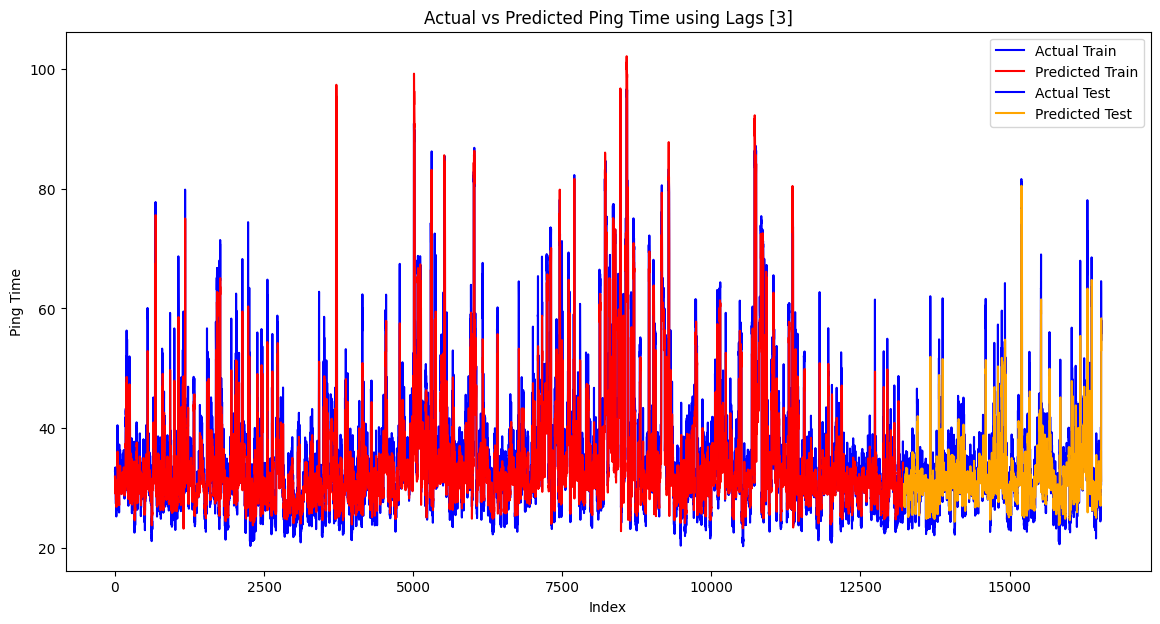

Epoch 1/50
Epoch 1: loss = 0.2684604525566101
207/207 - 7s - loss: 0.2685 - 7s/epoch - 32ms/step
Epoch 2/50
Epoch 2: loss = 0.14549152553081512
207/207 - 4s - loss: 0.1455 - 4s/epoch - 19ms/step
Epoch 3/50
Epoch 3: loss = 0.09413393586874008
207/207 - 4s - loss: 0.0941 - 4s/epoch - 19ms/step
Epoch 4/50
Epoch 4: loss = 0.06060303375124931
207/207 - 4s - loss: 0.0606 - 4s/epoch - 18ms/step
Epoch 5/50
Epoch 5: loss = 0.037632979452610016
207/207 - 4s - loss: 0.0376 - 4s/epoch - 19ms/step
Epoch 6/50
Epoch 6: loss = 0.02494225464761257
207/207 - 4s - loss: 0.0249 - 4s/epoch - 19ms/step
Epoch 7/50
Epoch 7: loss = 0.01675315573811531
207/207 - 4s - loss: 0.0168 - 4s/epoch - 19ms/step
Epoch 8/50
Epoch 8: loss = 0.011774023994803429
207/207 - 4s - loss: 0.0118 - 4s/epoch - 19ms/step
Epoch 9/50
Epoch 9: loss = 0.009079858660697937
207/207 - 4s - loss: 0.0091 - 4s/epoch - 19ms/step
Epoch 10/50
Epoch 10: loss = 0.007071299012750387
207/207 - 4s - loss: 0.0071 - 4s/epoch - 19ms/step
Epoch 11/50
Epo

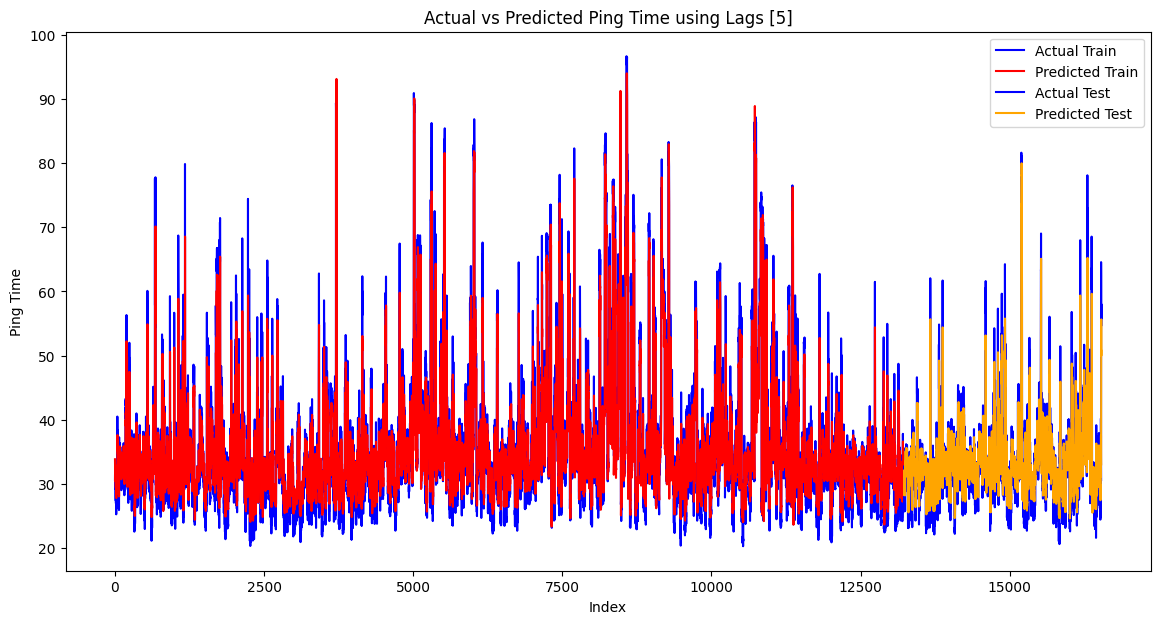

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LambdaCallback

# Load and preprocess the initial batch of data
file_path = 'o1.txt'  # Update this path to the actual file location
with open(file_path, 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    match = re.search(r'\[(\d+\.\d+)\] 64 bytes from .+ time=(\d+\.\d+)', line)
    if match:
        timestamp = float(match.group(1))
        ping_time = float(match.group(2))
        data.append([timestamp, ping_time])

df = pd.DataFrame(data, columns=['Timestamp', 'Ping Time'])

# Converting the timestamps to UTC
df['UTC Time'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)
df['Rounded Time'] = df['UTC Time'].dt.round('S')

# Calculating the average ping time for each second
average_ping_per_second = df.groupby('Rounded Time')['Ping Time'].mean().reset_index()

# Feature Engineering - Adding Lag Features
def add_lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['Ping Time'].shift(lag)
    df.dropna(inplace=True)
    return df

# Normalize the data
scaler = MinMaxScaler()

# Convert to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20

# Define the model creation function with parameters
def create_best_model(input_shape, units, dropout_rate, optimizer):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to evaluate and plot the model
def evaluate_and_plot(lags, best_params):
    df_lagged = add_lag_features(average_ping_per_second.copy(), lags)
    scaled_data = scaler.fit_transform(df_lagged[['Ping Time'] + [f'Lag_{lag}' for lag in lags]])
    X, y = create_sequences(scaled_data, SEQ_LENGTH)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = create_best_model((SEQ_LENGTH, X_train.shape[2]), best_params['model__units'], best_params['model__dropout_rate'], best_params['model__optimizer'])

    # Callback to output loss at each epoch
    epoch_logger = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1}: loss = {logs['loss']}"))

    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=2, callbacks=[epoch_logger])

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_pred = scaler.inverse_transform(np.concatenate((y_train_pred.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
    y_test_pred = scaler.inverse_transform(np.concatenate((y_test_pred.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Lags: {lags}')
    print(f'Training Mean Absolute Error: {train_mae}')
    print(f'Training R^2 Score: {train_r2}')
    print(f'Testing Mean Absolute Error: {test_mae}')
    print(f'Testing R^2 Score: {test_r2}')
    print('-' * 30)
    
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_train)), y_train, color='blue', label='Actual Train')
    plt.plot(range(len(y_train)), y_train_pred, color='red', label='Predicted Train')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, color='blue', label='Actual Test')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred, color='orange', label='Predicted Test')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Ping Time')
    plt.title(f'Actual vs Predicted Ping Time using Lags {lags}')
    plt.show()

# Best parameters for each lag configuration
best_params_lags_1 = {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__optimizer': Adam(), 'model__units': 100}
best_params_lags_3 = {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__optimizer': Adam(), 'model__units': 50}
best_params_lags_5 = {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.1, 'model__optimizer': Adam(), 'model__units': 50}

# Evaluate and plot for each lag configuration
evaluate_and_plot([1], best_params_lags_1)
evaluate_and_plot([3], best_params_lags_3)
evaluate_and_plot([5], best_params_lags_5)


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

# Load and preprocess the initial batch of data
file_path = 'o1.txt'  # Update this path to the actual file location
with open(file_path, 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    match = re.search(r'\[(\d+\.\d+)\] 64 bytes from .+ time=(\d+\.\d+)', line)
    if match:
        timestamp = float(match.group(1))
        ping_time = float(match.group(2))
        data.append([timestamp, ping_time])

df = pd.DataFrame(data, columns=['Timestamp', 'Ping Time'])

# Converting the timestamps to UTC
df['UTC Time'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)
df['Rounded Time'] = df['UTC Time'].dt.round('S')

# Calculating the average ping time for each second
average_ping_per_second = df.groupby('Rounded Time')['Ping Time'].mean().reset_index()

# Feature Engineering - Adding Lag Features
def add_lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['Ping Time'].shift(lag)
    df.dropna(inplace=True)
    return df

# Normalize the data
scaler = MinMaxScaler()

# Convert to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20

# Define the model creation function with parameters
def create_best_model(input_shape, units, dropout_rate, optimizer):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Custom callback to print loss at the end of each epoch
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}: loss = {logs["loss"]:.4f}')
        
# Function to evaluate and plot the model
def evaluate_and_plot_online(lags, best_params):
    df_lagged = add_lag_features(average_ping_per_second.copy(), lags)
    scaled_data = scaler.fit_transform(df_lagged[['Ping Time'] + [f'Lag_{lag}' for lag in lags]])
    X, y = create_sequences(scaled_data, SEQ_LENGTH)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = create_best_model((SEQ_LENGTH, X_train.shape[2]), best_params['model__units'], best_params['model__dropout_rate'], best_params['model__optimizer'])

    # Online learning - train in small batches
    for epoch in range(best_params['epochs']):
        for i in range(0, len(X_train), best_params['batch_size']):
            X_batch = X_train[i:i + best_params['batch_size']]
            y_batch = y_train[i:i + best_params['batch_size']]
            model.fit(X_batch, y_batch, epochs=1, batch_size=best_params['batch_size'], verbose=0, callbacks=[CustomCallback()], shuffle=False)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_pred = scaler.inverse_transform(np.concatenate((y_train_pred.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
    y_test_pred = scaler.inverse_transform(np.concatenate((y_test_pred.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

    y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Lags: {lags}')
    print(f'Training Mean Absolute Error: {train_mae}')
    print(f'Training R^2 Score: {train_r2}')
    print(f'Testing Mean Absolute Error: {test_mae}')
    print(f'Testing R^2 Score: {test_r2}')
    print('-' * 30)
    
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_train)), y_train, color='blue', label='Actual Train')
    plt.plot(range(len(y_train)), y_train_pred, color='red', label='Predicted Train')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, color='blue', label='Actual Test')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred, color='orange', label='Predicted Test')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Ping Time')
    plt.title(f'Actual vs Predicted Ping Time using Lags {lags}')
    plt.show()

# Best parameters for each lag configuration
best_params_lags_1 = {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__optimizer': Adam(), 'model__units': 100}
best_params_lags_3 = {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__optimizer': Adam(), 'model__units': 50}
best_params_lags_5 = {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.1, 'model__optimizer': Adam(), 'model__units': 50}

# Evaluate and plot for each lag configuration with online learning
evaluate_and_plot_online([1], best_params_lags_1)
evaluate_and_plot_online([3], best_params_lags_3)
evaluate_and_plot_online([5], best_params_lags_5)


Epoch 1: loss = 1.1791
Epoch 1: loss = 0.7328
Epoch 1: loss = 1.1591
Epoch 1: loss = 1.1089
Epoch 1: loss = 1.0356
Epoch 1: loss = 0.8775
Epoch 1: loss = 0.9727
Epoch 1: loss = 1.0899
Epoch 1: loss = 1.1391
Epoch 1: loss = 1.2097
Epoch 1: loss = 1.1589
Epoch 1: loss = 0.9359
Epoch 1: loss = 0.9176
Epoch 1: loss = 1.2439
Epoch 1: loss = 0.8367
Epoch 1: loss = 0.5263
Epoch 1: loss = 0.9413
Epoch 1: loss = 0.4972
Epoch 1: loss = 0.8390
Epoch 1: loss = 1.0316
Epoch 1: loss = 1.0134
Epoch 1: loss = 0.6382
Epoch 1: loss = 0.2586
Epoch 1: loss = 0.9367
Epoch 1: loss = 0.5589
Epoch 1: loss = 0.5917
Epoch 1: loss = 0.6140
Epoch 1: loss = 0.7290
Epoch 1: loss = 0.5816
Epoch 1: loss = 0.9803
Epoch 1: loss = 0.5561
Epoch 1: loss = 0.5920
Epoch 1: loss = 0.8347
Epoch 1: loss = 1.0095
Epoch 1: loss = 0.5721
Epoch 1: loss = 1.0273
Epoch 1: loss = 0.9672
Epoch 1: loss = 0.6761
Epoch 1: loss = 0.8952
Epoch 1: loss = 0.6694
Epoch 1: loss = 0.6867
Epoch 1: loss = 0.9908
Epoch 1: loss = 1.1697
Epoch 1: lo

KeyboardInterrupt: 